In [1]:
import numpy as np # linear algebra
import scipy as scipy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import dill

import keras as k
import cv2
from tqdm import tqdm


Using Theano backend.


In [35]:
with open('tiffs.pkl', 'rb') as in_strm:
    all_info = dill.load(in_strm)
x_train = np.array(all_info[0], dtype=np.float64)
x_test = all_info[1]
y_train = all_info[2]
y_test = all_info[3]
print(x_train.shape)

(35000, 32, 32, 4)


In [25]:
red_dct = scipy.fftpack.dct(x_train[:,:,:,0].astype(np.float64), axis=0)
green_dct = scipy.fftpack.dct(x_train[:,:,:,1].astype(np.float64), axis=0)
blue_dct = scipy.fftpack.dct(x_train[:,:,:,2].astype(np.float64), axis=0)
nir_dct = scipy.fftpack.dct(x_train[:,:,:,3].astype(np.float64), axis=0)
train_dct = np.array([red_dct, green_dct, blue_dct, nir_dct])
train_dct = train_dct.reshape((train_dct.shape[1], train_dct.shape[2], 
                               train_dct.shape[3], train_dct.shape[0]))
print(train_dct.shape)

(35000, 32, 32, 4)


In [26]:
red_dct = scipy.fftpack.dct(x_test[:,:,:,0].astype(np.float64), axis=0)
green_dct = scipy.fftpack.dct(x_test[:,:,:,1].astype(np.float64), axis=0)
blue_dct = scipy.fftpack.dct(x_test[:,:,:,2].astype(np.float64), axis=0)
nir_dct = scipy.fftpack.dct(x_test[:,:,:,3].astype(np.float64), axis=0)
test_dct = np.array([red_dct, green_dct, blue_dct, nir_dct])
test_dct = test_dct.reshape((test_dct.shape[1], test_dct.shape[2], 
                               test_dct.shape[3], test_dct.shape[0]))
print(test_dct.shape)

(5479, 32, 32, 4)


In [36]:
train_dct_copy = np.copy(train_dct)
x_train_copy = np.copy(x_train)

x_train_copy -= np.mean(x_train_copy, axis=0)
std = np.std(x_train_copy, axis = 0)
print(std)
print(std.shape)
x_train_copy /= np.std(x_train_copy, axis = 0)
train_dct_copy -= np.mean(train_dct_copy, axis=0)
train_dct_copy /= np.std(train_dct_copy, axis = 0)

print(x_train_copy)
print(train_dct_copy)

[[[ 7.05030755  6.38912329  6.52947956  7.34003592]
  [ 7.04290947  6.38692558  6.52760056  7.33042757]
  [ 7.05933609  6.39443475  6.54585631  7.34618407]
  ..., 
  [ 7.01405778  6.28588932  6.47158769  7.2961809 ]
  [ 7.02764469  6.29797448  6.48131289  7.2721521 ]
  [ 7.0121155   6.30772535  6.46758315  7.289453  ]]

 [[ 7.04679311  6.3554104   6.51285994  7.31711263]
  [ 7.0088147   6.3407686   6.49056341  7.31779294]
  [ 7.01768678  6.36864695  6.50188913  7.32460943]
  ..., 
  [ 6.99446467  6.28547508  6.46398811  7.26320928]
  [ 7.00265443  6.29161015  6.4606894   7.27847263]
  [ 6.98666054  6.28435573  6.43388024  7.28551558]]

 [[ 7.06092077  6.3604084   6.51571678  7.30412302]
  [ 7.03301817  6.33492734  6.49040487  7.29772004]
  [ 7.03293033  6.33713904  6.49691405  7.32148687]
  ..., 
  [ 7.0098163   6.29247768  6.47015442  7.31157006]
  [ 6.98246111  6.28287498  6.42998047  7.30518669]
  [ 6.98808862  6.29693429  6.44154324  7.29218925]]

 ..., 
 [[ 7.07506822  6.31628279 

In [29]:
print(np.any(np.isnan(x_train_copy)))
print(np.any(np.isnan(train_dct_copy)))

False
False


In [30]:
print(x_train)

[[[[ 20.375       17.0625      11.046875    25.        ]
   [ 20.625       17.28125     11.359375    25.40625   ]
   [ 20.546875    17.28125     11.265625    21.890625  ]
   ..., 
   [ 20.25        17.015625    10.9609375   24.328125  ]
   [ 20.296875    16.9375      11.0546875   24.921875  ]
   [ 19.828125    16.65625     10.5859375   23.5       ]]

  [[ 20.40625     17.234375    10.8671875   23.375     ]
   [ 20.375       17.109375    11.015625    23.1875    ]
   [ 20.140625    16.78125     11.0078125   21.515625  ]
   ..., 
   [ 19.890625    16.71875     10.59375     23.21875   ]
   [ 19.734375    16.65625     10.53125     23.359375  ]
   [ 20.28125     16.953125    10.9296875   23.1875    ]]

  [[ 20.4375      16.953125    11.015625    23.515625  ]
   [ 20.359375    16.75        10.796875    20.84375   ]
   [ 19.96875     16.609375    10.7265625   22.71875   ]
   ..., 
   [ 20.0625      16.65625     10.71875     20.765625  ]
   [ 19.875       16.46875     10.6953125   22.625     ]


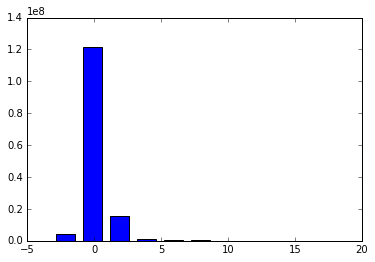

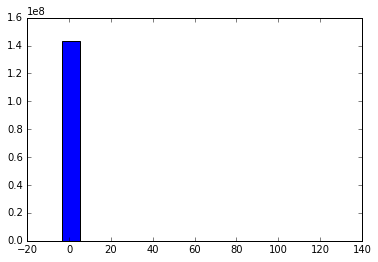

In [39]:
import matplotlib.pyplot as plt
hist, bins = np.histogram(x_train_copy, bins=10)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

hist, bins = np.histogram(train_dct_copy, bins=10)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()


#ah...must be some nans in there. check this later

Extracting features for x_train

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers.merge import concatenate
from keras.optimizers import Adam

#baseline part
original_input = Input(shape=(32, 32, 4))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(original_input)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
max1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop1 = Dropout(0.25)(max1)
flat1 = Flatten()(drop1)
dense1 = Dense(128, activation='relu')(flat1)
drop2 = Dropout(0.5)(dense1)

#mean
dct_input = Input(shape=(32, 32, 4))
conv3 = Conv2D(32, kernel_size=(3, 3), activation='relu')(dct_input)
drop3 = Dropout(0.25)(conv3)
flat2 = Flatten()(drop3)
dense5 = Dense(128, activation='relu')(flat2)
drop4 = Dropout(0.5)(dense5)


combine = concatenate([drop2, drop4])
dense3 = Dense(256, activation='relu')(combine)
dense4 = Dense(17, activation='sigmoid', name='test')(dense3)



model = Model(inputs=[original_input, dct_input], outputs=dense4)

adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
                    optimizer=adam,
                    metrics=['accuracy'])


weights = model.get_layer('test').get_weights()
print(len(weights))
print(weights[0])
print(weights[1])



model.fit([x_train_copy, train_dct_copy],
          y_train, batch_size=128, epochs=2, verbose=1, validation_data=([x_test, test_dct], y_test))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('test').output)
intermediate_output = intermediate_layer_model.predict([x_train, train_means])
print(intermediate_output[0])

from sklearn.metrics import fbeta_score

p_valid = model.predict(x_test, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

2
[[-0.02497464 -0.02946332 -0.02314411 ...,  0.01595762  0.030854
   0.06333652]
 [-0.13630681 -0.06772669  0.05626422 ..., -0.03566147 -0.13165073
   0.02563813]
 [-0.14125754 -0.06530602 -0.11243252 ...,  0.02571183  0.07110041
  -0.05921592]
 ..., 
 [ 0.00304371  0.11978009 -0.01590128 ...,  0.03912251  0.04287058
  -0.09276173]
 [-0.00554954 -0.00625539  0.10641021 ..., -0.09541366 -0.04510657
  -0.11632757]
 [ 0.14085615  0.01339529  0.14213949 ..., -0.12838235  0.06161901
  -0.06508179]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Train on 35000 samples, validate on 5479 samples
Epoch 1/2
 1152/35000 [..............................] - ETA: 289s - loss: 0.5066 - acc: 0.7573

KeyboardInterrupt: 

Debugging analysis: 
1. Make x_train and y_train into double-type arrays, otherwise will end up with infinities. Check your data!!
2. Normalize each feature separately
3. Follow cs231n exactly (find std after subtracting mean):
    X -= np.mean(X, axis = 0)
    X /= np.std(X, axis = 0)
4. Always check for nans and infs!!!